In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data and model

In [53]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              img_size=256,
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0][0:1]

# load model
model = load_model(model_name='resnet18', device=device, data_path=p.data_path)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

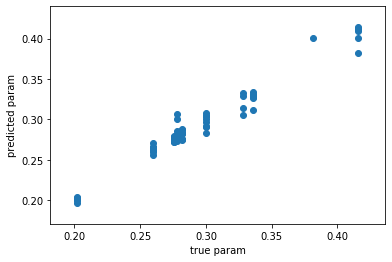

In [54]:
with torch.no_grad():
    im, params = iter(train_loader).next()
    im = im.to(device)
    preds = model(im)[:,1].cpu()
    params = params[:,1]
# print(result)
plt.scatter(params, preds)
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()    

## wavelet

In [55]:
class Mask_WaveCoeffs(nn.Module):
    def __init__(self, img_size=256, J=5, device='cuda'):
        super(Mask_WaveCoeffs, self).__init__()
        self.img_size = img_size
        self.num = J+1

        # initialize masks 
        x = torch.randn(1,1,img_size,img_size).to(device)
        xfm = DTCWTForward(J=J, biort='near_sym_b', qshift='qshift_b').to(device)
        Yl, Yh = xfm(x)   
        
        self.mask = nn.ParameterList([nn.Parameter(torch.ones_like(Yl))])
        for i in range(J):
            self.mask.append(nn.Parameter(torch.ones_like(Yh[i])))
            
        
    def forward(self, x):
        output_list = []
        for i in range(self.num):
            output_list.append(torch.mul(x[i], self.mask[i]))
        return tuple(output_list)
    
    
    def projection(self):
        for i in range(self.num):
            self.mask[i].data = torch.clamp(self.mask[i].data, 0, 1)
        
        
class Wavelet_Transform(nn.Module):
    def __init__(self, J=5, device='cuda'): 
        super(Wavelet_Transform, self).__init__()
        self.xfm = DTCWTForward(J=5, biort='near_sym_b', qshift='qshift_b').to(device)
        self.J = J
        
    
    def forward(self, x):
        Yl, Yh = self.xfm(x)
        output_list = [Yl]
        for i in range(self.J):
            output_list.append(Yh[i])        
        return tuple(output_list)
    
    
class Wavelet_iTransform(nn.Module):
    def __init__(self, J=5, device='cuda'): 
        super(Wavelet_iTransform, self).__init__()
        self.ifm = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').to(device)
        self.J = J
        
    
    def forward(self, x):
        x = list(x)
        Yl = x.pop(0)
        Yh = x
        return self.ifm((Yl, Yh))
    
    
class InputXGradient(nn.Module):
    def __init__(self, mt, target=1, device='cuda'): 
        super(InputXGradient, self).__init__()
        self.mt = mt.to(device)
        self.target = target
        
        
    def forward(self, x):
        n = len(x)
        for i in range(n):
            x[i].retain_grad()
        output = self.mt(x)[0][self.target]
        output.backward(retain_graph=True)
        
        # input * gradient
        scores = []
        for i in range(n):
            scores.append(torch.mul(x[i], x[i].grad))
        return tuple(scores)    
    
    
def tuple_sum(x):
    norm = 0
    num = len(x)
    for i in range(num):
        norm += torch.mean(x[i])
    return norm    
        

In [56]:
# input
torch.manual_seed(p.seed)
im = iter(train_loader).next()[0][0:1].to(device)
im.requires_grad = True

# wavelet transform
xfm = Wavelet_Transform(J=5)
ifm = Wavelet_iTransform(J=5)

# prepend transformation onto network
model_t = TrimModel(model, ifm)

# interp score
attributer = InputXGradient(model_t, target=1)

num_epochs = 1000

num_lamb = 20
lamb_l1 = np.geomspace(0.01, 1, num_lamb)
Losses = []
masks = []

for i, lamb in enumerate(lamb_l1):
    # mask
    mask = Mask_WaveCoeffs(img_size=256, J=5)
    # Setup Adam optimizer
    optimizer = torch.optim.Adam(mask.parameters(), lr=0.01)
    
    # Training Loop
    # Lists to keep track of progress
    losses = []

    print("\nStarting Training Loop...")
    print("Lambda {}/{}".format(i, len(lamb_l1)))
    # For each epoch
    for epoch in range(num_epochs):
        im_mask = mask(xfm(im))
        im_ = ifm(im_mask)
        output_ = model(im_).flatten()[1] 
        loss = -output_ + lamb * tuple_sum(mask.mask)
        # zero grad
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update G
        optimizer.step()
        # projection
        mask.projection()

        # Output training stats
        print('\rTrain Epoch: {}/{}'.format(epoch+1, num_epochs), end='')

        # Save Losses for plotting later
        losses.append(loss.item())
    Losses.append(losses)
    masks.append(mask)



Starting Training Loop...
Lambda 0/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 1/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 2/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 3/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 4/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 5/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 6/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 7/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 8/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 9/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 10/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 11/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 12/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 13/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 14/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 15/20
Train Epoch: 1000/1000
Starting Training

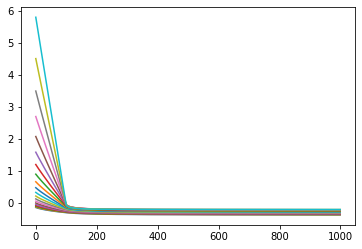

In [57]:
for i in range(num_lamb):
    plt.plot(Losses[i])
plt.show()

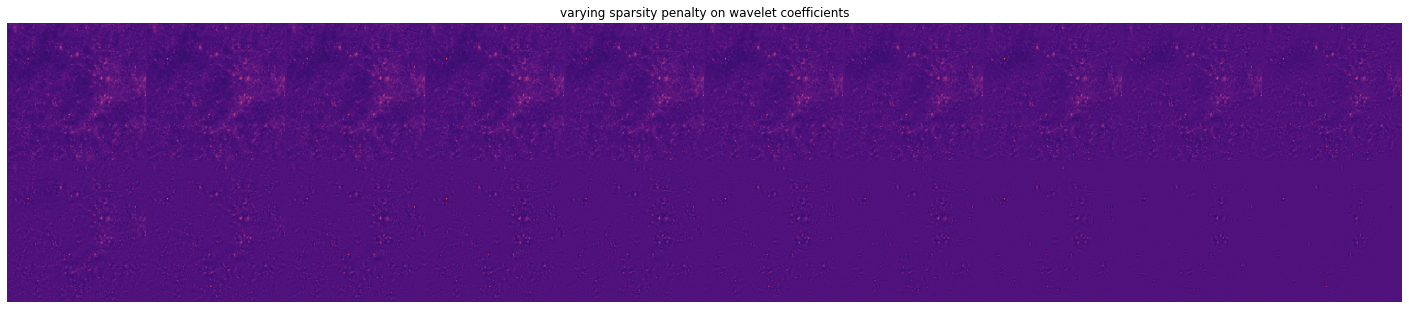

In [58]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
p = 256 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im_ = ifm(masks[indx](xfm(im))).squeeze().data.cpu().numpy()
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im_,(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

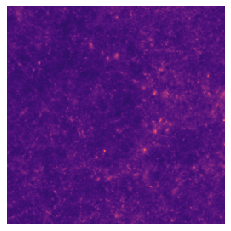

In [59]:
cshow(im.data.cpu().squeeze())